In [232]:
# from __future__ import print_function
from __future__ import division

import json
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import gzip
from scipy.misc import imsave
import time
import scipy.ndimage

from keras import backend as K
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Dropout

from keras.layers import *
from keras.layers.merge import concatenate
from keras.models import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, Callback
from keras import losses

from keras.preprocessing.image import ImageDataGenerator

from scipy.ndimage import morphology

import random
from itertools import islice

In [233]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


In [6]:
cd ..

/home/malub_local/activelearningADS


## Utils

In [285]:
def preprocessor(input_img, img_rows, img_cols):
    """
    Resize input images to constants sizes
    :param input_img: numpy array of images
    :return: numpy array of preprocessed images
    """
    output_img = np.ndarray((input_img.shape[0], input_img.shape[1], img_rows, img_cols), dtype=np.uint8)
    
    for i in range(input_img.shape[0]):
        output_img[i, 0] = cv2.resize(input_img[i, 0], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
    
    return output_img


def load_data(path_img, path_mask, img_rows, img_cols):
    """
    Load data from project path
    :return: [X, y] numpy arrays containing the [training, validation, test] data and their respective masks.
    """
    print("\nLoading data...\n")
    X = np.load(path_img)
    y = np.load(path_mask)

    X = preprocessor(X, img_rows, img_cols)
    y = preprocessor(y, img_rows, img_cols)

    X = X.astype('float32')

    mean = np.mean(X)  # mean for data centering
    std = np.std(X)  # std for data normalization

    X -= mean
    X /= std

    y = y.astype('float32')
    y /= 255.  # scale masks to [0, 1]
    return X, y


#### loss and metrics #####
def dice_coef(y_true, y_pred, smooth = 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


"""def dice_coef(y_true, y_pred, smooth=1):

    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)"""



def weighted_binary_crossentropy(y_true, y_pred):
        # Calculate the binary crossentropy
    b_ce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights
    weight_vector = y_true * 0.30 + (1. - y_true) * 0.70
    weighted_b_ce = weight_vector * b_ce

        # Return the mean error
    return K.mean(weighted_b_ce)


### data augmentation ######
def data_generator():
    """
    :return: Keras data generator. Data augmentation parameters.
    """
    return ImageDataGenerator(
        fill_mode = fill_mode,
        rotation_range = rotation_range,
        horizontal_flip = horizontal_flip,
        vertical_flip = vertical_flip,
        rescale = rescale,
        zoom_range = zoom_range,
        channel_shift_range = channel_shift_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range)
        #preprocessing_function = random_gaussian_noise)

def random_gaussian_noise(image):
    apply_gaussian_noise = random.choice([True, False])
    if apply_gaussian_noise == True:
        output_image = noisy(image)
    else:
        output_image = image
    return output_image
    

def noisy(image):
    ch, row, col = image.shape
    mean = 0
    sigma = np.random.uniform(low=0.0, high=sigma_max, size=None)
    gauss = np.random.normal(mean, sigma, (ch, row,col))
    gauss = gauss.reshape(ch, row,col)
    noisy = image + gauss
    return noisy


#Override Dropout. Make it able at test time.
def call(self, inputs, training=None):
    if 0. < self.rate < 1.:
        noise_shape = self._get_noise_shape(inputs)
        def dropped_inputs():
            return K.dropout(inputs, self.rate, noise_shape,
                             seed=self.seed)
        if (training):
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        else:
            return K.in_test_phase(dropped_inputs, inputs, training=None)
    return inputs

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

            
            
def predict(data, model):
    """
    Data prediction for a given model
    :param data: input data to predict.
    :param model: unet model.
    :return: predictions.
    """
    return model.predict(data, verbose=0)

def compute_dice_coef(y_true, y_pred):
    """
    Computes the Dice-Coefficient of a prediction given its ground truth.
    :param y_true: Ground truth.
    :param y_pred: Prediction.
    :return: Dice-Coefficient value.
    """
    smooth = 1.  # smoothing value to deal zero denominators.
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def compute_uncertain(sample, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: overall uncertainty (not map) .
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)
    X_prediction = cv2.threshold(np.mean(X, axis=0), threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return np.sum(var * transform)

    else:
        return X_prediction, np.sum(np.var(X, axis=0))

def compute_uncertain_map(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: uncertainty map.
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return var * transform

    else:
        return np.var(X, axis=0)  

## Unet

In [284]:
def unet_full_bn(dropout):
    inputs = Input((1, img_rows, img_cols))
    #x = GaussianNoise(noise)(inputs)
    #conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)
    pool1 = Dropout(dropout_proba)(pool1)


    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)
    pool2 = Dropout(dropout_proba)(pool2)

   
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)
    pool3 = Dropout(dropout_proba)(pool3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)
    
    if dropout:
        pool4 = Dropout(dropout_proba)(pool4)
   
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(conv5)

    if dropout:
        conv5 = Dropout(dropout_proba)(conv5)    

    up6_interm = UpSampling2D(size=(2, 2))(conv5)
    
    up6 = concatenate([up6_interm, conv4], axis=1)

    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv6)
    batch6 = BatchNormalization(axis=1)(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    
    if dropout:
        up7 = Dropout(dropout_proba)(up7)  
        
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv7)
    batch7 = BatchNormalization(axis=1)(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(batch7), conv2], axis=1)
    up8 = Dropout(dropout_proba)(up8)

    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv8)
    batch8 = BatchNormalization(axis=1)(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(batch8), conv1], axis=1)
    up9 = Dropout(dropout_proba)(up9)

    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation="sigmoid")(batch9)

    #model = Model(input=inputs, output=conv10)
    model = Model(outputs=conv10, inputs=inputs)

    #model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
    #model.compile(optimizer=Adam(lr=1e-3), loss=losses.binary_crossentropy, metrics = [dice_coef])
    model.compile(optimizer=Adam(lr = learning_rate, decay=decay_rate), loss=weighted_binary_crossentropy, 
                  metrics = [dice_coef])

    return model

In [268]:
def save_parameters(timestamp, params):
    param_file = str(param_path + 'params_' + timestamp + '.txt')
    txt_file = open(param_file,'w')
    txt_file.write(str(params))
    txt_file.close()
    
def get_params():
    param_dict = {
    'img_rows':img_rows,
    'img_cols' : img_cols,
    'batch_size' : batch_size,
    'fill_mode' : fill_mode,
    'rotation_range': rotation_range,
    'horizontal_flip': horizontal_flip,
    'vertical_flip' : vertical_flip,
    'rescale' : rescale,
    'zoom_range': zoom_range,
    'channel_shift_range' : channel_shift_range,
    'width_shift_range' : width_shift_range,
    'height_shift_range' : height_shift_range,
    'nb_initial_epochs' : nb_initial_epochs,
    'apply_augmentation' : apply_augmentation,
    'nb_step_predictions': nb_step_predictions,
    'steps_per_epoch' : steps_per_epoch,
    'learning_rate' : learning_rate,
    'decay_rate' : decay_rate,
    'apply_edt' : apply_edt
    }
    return param_dict

## Score measure

In [269]:
## Score measure

def jaccard_score(seg, gt):
    intersection = (seg*gt).sum()
    union = seg.sum()+gt.sum()-intersection
    if union == 0:
        return 1.
    else:
        return float(intersection)/union
    
def pixel_wise_accuracy(y_true, y_pred):
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    return 1 - np.count_nonzero(y_pred_f - y_true_f) / y_true_f.shape[1]
    

def distances(pred, gt):
    d1 = morphology.distance_transform_edt(1-gt)*pred
    d2 = morphology.distance_transform_edt(1-pred)*gt
    return d1, d2


def numeric_score(y_pred, y_true):
    y_pred = y_pred.astype(int)
    y_true = y_true.astype(int)
    FP = float(np.sum((y_pred == 1) & (y_true == 0)))
    FN = float(np.sum((y_pred == 0) & (y_true == 1)))
    TP = float(np.sum((y_pred == 1) & (y_true == 1)))
    TN = float(np.sum((y_pred == 0) & (y_true == 0)))
    return FP, FN, TP, TN

def precision_score(y_pred, y_true):
    # PPV
    FP, FN, TP, TN = numeric_score(y_pred, y_true)
    if (TP + FP) <= 0:
        return 0.
    else:
        return np.divide(TP, TP + FP) 
    

def sensitivity_score(y_pred, y_true):
    # TPR, sensitivity
    FP, FN, TP, TN = numeric_score(y_pred, y_true)
    if (TP + FN) <= 0:
        return 0.
    else:
        return np.divide(TP, TP + FN) 



In [270]:
## Rank the most uncertain predictions

def to_be_annotated(uncertain, n):
    """Return index of the most n uncertain predictions"""
    return np.flip(np.argsort(uncertain), 0)[:n]

def add_annotated_sample(original, added, added_index):
    """append the annotated samples to the training set"""
    return np.vstack((original, added[added_index] ))


def remove_annotated(original, added_index):
    """remove annotated samples from unlabelled dataset"""
    new_index = np.delete(np.arange(len(original)), added_index)
    return original[new_index]


## Active Learing loop

In [286]:
def save_history(history, timestamp, iteration, history_path):
    history_file = str(history_path + timestamp + '_history_iter_' +  str(iteration) +'_' + '.txt')
    txt_file = open(history_file,'w')
    txt_file.write(str(history))
    txt_file.close()
    
def scores(model, X_test, y_test, score_global ):
    uncertain_map = []
    uncertain = np.zeros(len(X_test))
    dice = np.zeros(len(X_test))
    jaccard = np.zeros(len(X_test))
    accuracy = np.zeros(len(X_test))
    sensitivity = np.zeros(len(X_test))
    precision = np.zeros(len(X_test))
    
    print("Computing predictions ...\n")
    predictions = predict(X_test, model)

    for i in range(len(X_test)):
        sample = X_test[i].reshape([1, 1, img_rows, img_cols])
        sample_prediction = cv2.threshold(predictions[i], 0.6, 1, cv2.THRESH_BINARY)[1].astype('uint8')
        dice[i] = compute_dice_coef(y_test[i][0], sample_prediction)
        jaccard[i] = jaccard_score(sample_prediction, y_test[i][0, :, :])
        accuracy[i] = pixel_wise_accuracy(sample_prediction, y_test[i][0, :, :])
        sensitivity[i] = sensitivity_score(sample_prediction, y_test[i][0, :, :])
        precision[i] = precision_score(sample_prediction, y_test[i][0, :, :])
        uncertain[i] = compute_uncertain(sample, sample_prediction, model)
        uncertain_map_i = compute_uncertain_map(sample, sample_prediction, model)
        uncertain_map.append(uncertain_map_i)

    uncertain_map_array = np.asarray(uncertain_map)
    print(uncertain_map_array.shape)
    print("Done computing predictions")

    metrics_array = np.array([np.mean(dice), np.mean(jaccard), np.mean(accuracy), np.mean(precision),
                                np.mean(sensitivity)])
    score_global = np.vstack((score_global, metrics_array))
    
    return score_global

def balance_uncertainty(sample_pred, uncertainty):
    ratio = (0.5 / (np.count_nonzero(sample_pred) / (512*512* 1.0)))
    print(np.count_nonzero(sample_pred), ratio, "\n")
    return uncertainty*ratio

def uncertainty_for_ranking(model, X_set):
    # uncertainty computation for unlabelled
    print("Computing predictions for unlabelled data ...\n")
    uncertain_map = []
    uncertainty = np.zeros(len(X_set))
    predictions = predict(X_set, model)
    for i in range(len(X_set)):
        sample = X_set[i].reshape([1, 1, img_rows, img_cols])
        sample_prediction = cv2.threshold(predictions[i], 0.6, 1, cv2.THRESH_BINARY)[1].astype('uint8')
        
        X_i, uncertainty_i = compute_uncertain(sample, sample_prediction, model)
        
        uncertainty[i] = balance_uncertainty(X_i, compute_uncertain(sample, model))
        
        uncertain_map_i = compute_uncertain_map(sample, sample_prediction, model)
        uncertain_map.append(uncertain_map_i)
    uncertain_map_array = np.asarray(uncertain_map)
    return uncertainty, uncertain_map, predictions

In [287]:
data_path = '../data/'
param_path = '../params/'

# PATH definition
checkpoint_weights_path = "./models/checkpoint_weights.hdf5"
final_weights_path = "./models/output_weights_batch_norm.hdf5"
intermediate_weights_path = "./models/intermediate_weights_batch_norm.hdf5"

path_img = '../data/full_images.npy'
path_mask = '../data/full_masks.npy'
history_path = '../history/'


# imag  e dimension (array)
img_rows = 512
img_cols = 512

batch_size = 8

# data augmentation
fill_mode = 'reflect'
rotation_range= 10
horizontal_flip= True
vertical_flip = True
rescale = 0
zoom_range= 0.3
channel_shift_range = 0.1
width_shift_range = 0.1
height_shift_range = 0.1

sigma_max = 0.3
noise = 0.5


K.set_image_dim_ordering('th')  # Theano dimension ordering in this code
smooth = 1.
Dropout.call = call

# training
nb_initial_epochs = 300
apply_augmentation = True
nb_step_predictions = 10
steps_per_epoch = 20
dropout_proba = 0.3

learning_rate = 1e-3
decay_rate = learning_rate / nb_initial_epochs

apply_edt = False


In [ ]:
# load data
X_full, y_full = load_data(path_img, path_mask, img_rows, img_cols )

# split data into train (labelled, 30%), unlabelled (active learning simulation, 50%), test (20%)
X_labelled_0 = X_full[:30]
y_labelled_0 = y_full[:30]

X_unlabelled_0 = X_full[30:80]
y_unlabelled_0 = y_full[30:80]

X_test = X_full[80:]
y_test = y_full[80:]

print("X_labelled shape = ", X_labelled_0.shape, "X_unlabelled shape = ", X_unlabelled_0.shape, 
      "X_test shape = ",X_test.shape)
print("------------DATA LOADING DONE---------")


# START ACTIVE LEARNING ITERATION
for i in range(4):
    model_path = "./models/AL_model_" + str(i) + ".hdf5"     # save trained model after each training
    print("------------Starting AL Iteration:", i, '----------')
    if i == 0: #initialization 
        X_labelled = X_labelled_0
        y_labelled = y_labelled_0
        X_unlabelled = X_unlabelled_0
        y_unlabelled = y_unlabelled_0
        score_global = np.zeros(5)
    else:
        # select the samples that are going to be annotated by expert
        index = to_be_annotated(uncertain_unlabelled, 10)

        # add this samples + masks to the train set 
        X_labelled = add_annotated_sample(X_labelled, X_unlabelled, index)
        y_labelled = add_annotated_sample(y_labelled, y_unlabelled, index)

        # remove them + masks from test set
        X_unlabelled = remove_annotated(X_unlabelled, index)
        y_unlabelled = remove_annotated(y_unlabelled, index)
        
        print("new_X_train shape = ", X_labelled.shape, "new_y_train shape =", y_labelled.shape)
        print("new_X_test shape=", X_unlabelled.shape, "new_y_test shape =", y_unlabelled.shape)
        
    # train - validation split
    split_index = int(len(X_labelled)*0.80)
    X_valid = X_labelled[split_index:]
    y_valid = y_labelled[split_index:]
    X_labelled = X_labelled[:split_index]
    y_labelled = y_labelled[:split_index]
    print("new_X_train shape = ", X_labelled.shape, "new_y_train shape =", y_labelled.shape)
    print("new_X_valid shape = ", X_valid.shape, "new_y_valid shape =", y_valid.shape)
    
    ## Retrain with new dataset

    # data augmentation
    seed = 1
    train_img_generator = data_generator().flow(X_labelled, seed = seed, batch_size = batch_size,  shuffle=False)
    train_mask_generator = data_generator().flow(y_labelled, seed = seed, batch_size = batch_size, shuffle=False)
    train_generator = zip(train_img_generator, train_mask_generator)
    
    
    # load model
    model = unet_full_bn(dropout = True)
    # retrain from scratch after each iteration
    reset_weights(model)
    
    # model checkpointing
    model_checkpoint = ModelCheckpoint(checkpoint_weights_path, monitor='loss', save_best_only = True)

    print("------------Starting training -----------")
    timestamp = format(time.strftime('%m%d_%H%M_%S'))
    save_parameters(format(time.strftime('%m%d_%H%M_%S')), get_params()) # save parameters
    tensorboard = TensorBoard(log_dir = str("../logs2/" + str(timestamp))) # tensorboard
    history = model.fit_generator(train_generator, 
                                    validation_data = (X_valid, y_valid), 
                                    epochs = nb_initial_epochs, 
                                    verbose = 1,
                                    shuffle = True,
                                    steps_per_epoch = steps_per_epoch, 
                                    callbacks = [tensorboard])
    
    save_history(history.history, timestamp, i, history_path) # save training history
    model.save(model_path) # save fully trained model
    print("------------Training done -----------")
    
    print("------------Starting ranking -----------")
    # compute predictions / uncertainty for ranking
    uncertain_unlabelled, uncertain_map, _ = uncertainty_for_ranking(model, X_unlabelled)
    
    print("------------Computing scores on test set -----------")
    # score computation on X_test
    score_global = scores(model, X_test, y_test, score_global)
    
    


Loading data...

('X_labelled shape = ', (30, 1, 512, 512), 'X_unlabelled shape = ', (50, 1, 512, 512), 'X_test shape = ', (18, 1, 512, 512))
------------DATA LOADING DONE---------
('------------Starting AL Iteration:', 0, '----------')
('new_X_train shape = ', (24, 1, 512, 512), 'new_y_train shape =', (24, 1, 512, 512))
('new_X_valid shape = ', (6, 1, 512, 512), 'new_y_valid shape =', (6, 1, 512, 512))
------------Starting training -----------
Epoch 1/300
20/20 [==============================] - 10s 481ms/step - loss: 0.2889 - dice_coef: 0.6154 - val_loss: 2.0182 - val_dice_coef: 0.3250
Epoch 2/300
20/20 [==============================] - 9s 428ms/step - loss: 0.2325 - dice_coef: 0.6539 - val_loss: 1.1627 - val_dice_coef: 0.1802
Epoch 3/300
20/20 [==============================] - 9s 430ms/step - loss: 0.2198 - dice_coef: 0.6568 - val_loss: 0.9525 - val_dice_coef: 0.1044
Epoch 4/300
20/20 [==============================] - 9s 427ms/step - loss: 0.2114 - dice_coef: 0.6604 - val_loss: 

20/20 [==============================] - 9s 428ms/step - loss: 0.1367 - dice_coef: 0.7757 - val_loss: 0.1880 - val_dice_coef: 0.6619
Epoch 55/300
20/20 [==============================] - 9s 428ms/step - loss: 0.1373 - dice_coef: 0.7753 - val_loss: 0.1938 - val_dice_coef: 0.7040
Epoch 56/300
20/20 [==============================] - 9s 427ms/step - loss: 0.1427 - dice_coef: 0.7725 - val_loss: 0.1808 - val_dice_coef: 0.6677
Epoch 57/300
20/20 [==============================] - 9s 427ms/step - loss: 0.1357 - dice_coef: 0.7811 - val_loss: 0.1794 - val_dice_coef: 0.7238
Epoch 58/300
20/20 [==============================] - 9s 427ms/step - loss: 0.1409 - dice_coef: 0.7793 - val_loss: 0.1877 - val_dice_coef: 0.7075
Epoch 59/300
20/20 [==============================] - 9s 428ms/step - loss: 0.1380 - dice_coef: 0.7804 - val_loss: 0.1704 - val_dice_coef: 0.6977
Epoch 60/300
20/20 [==============================] - 9s 428ms/step - loss: 0.1341 - dice_coef: 0.7849 - val_loss: 0.1829 - val_dice_coef

20/20 [==============================] - 9s 428ms/step - loss: 0.1162 - dice_coef: 0.8229 - val_loss: 0.1706 - val_dice_coef: 0.7471
Epoch 111/300
20/20 [==============================] - 9s 429ms/step - loss: 0.1163 - dice_coef: 0.8259 - val_loss: 0.1851 - val_dice_coef: 0.7101
Epoch 112/300
20/20 [==============================] - 9s 429ms/step - loss: 0.1161 - dice_coef: 0.8243 - val_loss: 0.1813 - val_dice_coef: 0.7260
Epoch 113/300
20/20 [==============================] - 9s 430ms/step - loss: 0.1203 - dice_coef: 0.8197 - val_loss: 0.1762 - val_dice_coef: 0.7304
Epoch 114/300
20/20 [==============================] - 9s 428ms/step - loss: 0.1182 - dice_coef: 0.8213 - val_loss: 0.1810 - val_dice_coef: 0.7345
Epoch 115/300
20/20 [==============================] - 9s 428ms/step - loss: 0.1170 - dice_coef: 0.8260 - val_loss: 0.1763 - val_dice_coef: 0.7070
Epoch 116/300
20/20 [==============================] - 9s 428ms/step - loss: 0.1210 - dice_coef: 0.8222 - val_loss: 0.1728 - val_dic

Epoch 166/300
20/20 [==============================] - 9s 428ms/step - loss: 0.1128 - dice_coef: 0.8352 - val_loss: 0.1861 - val_dice_coef: 0.7457
Epoch 167/300
20/20 [==============================] - 9s 429ms/step - loss: 0.1113 - dice_coef: 0.8380 - val_loss: 0.1738 - val_dice_coef: 0.7353
Epoch 168/300
20/20 [==============================] - 9s 428ms/step - loss: 0.1122 - dice_coef: 0.8412 - val_loss: 0.1854 - val_dice_coef: 0.7193
Epoch 169/300
20/20 [==============================] - 9s 428ms/step - loss: 0.1073 - dice_coef: 0.8425 - val_loss: 0.1817 - val_dice_coef: 0.7505
Epoch 170/300
20/20 [==============================] - 9s 427ms/step - loss: 0.1079 - dice_coef: 0.8423 - val_loss: 0.1787 - val_dice_coef: 0.7555
Epoch 171/300
20/20 [==============================] - 9s 427ms/step - loss: 0.1117 - dice_coef: 0.8392 - val_loss: 0.1793 - val_dice_coef: 0.7451
Epoch 172/300
20/20 [==============================] - 9s 429ms/step - loss: 0.1080 - dice_coef: 0.8426 - val_loss: 0.

In [250]:
score_global.shape

(5, 5)

# Analysis 

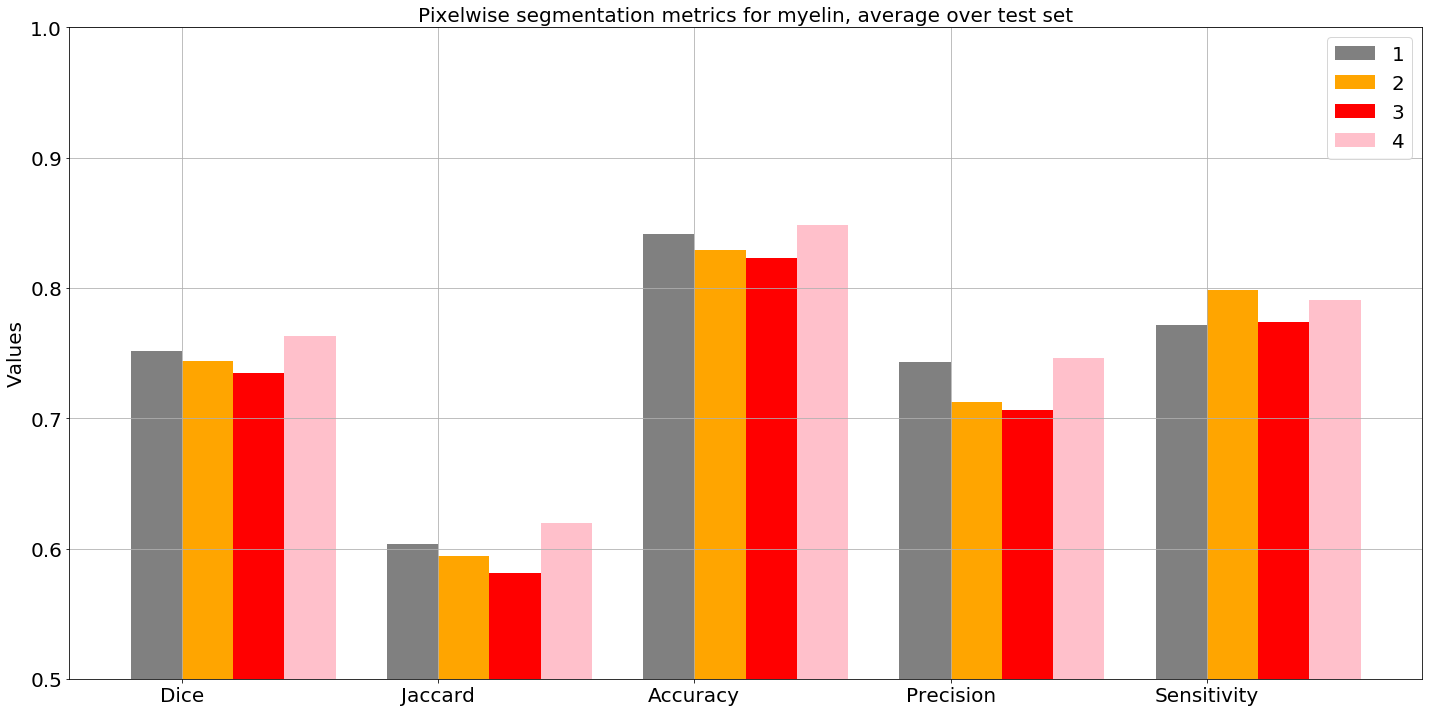

In [283]:
n_groups = 5
width=0.2
fig, ax = plt.subplots(figsize = (20, 10))
index = np.arange(n_groups)

for i in np.arange(1, 5, 1):
    plot = np.arange(-0.3, 1.6, width)
    color = "C" + str(i)
    color = ['black','grey', 'orange', 'red', 'pink']
    rects1 = plt.bar(index + plot[i], score_global[i], width=width, color=color[i],label=i)
    

plt.ylabel('Values',fontsize=20)
plt.title('Pixelwise segmentation metrics for myelin, average over test set',fontsize=20)
plt.xticks(index, ('Dice', 'Jaccard', 'Accuracy', 'Precision', 'Sensitivity'),fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best',fontsize=20)
plt.grid(True)
plt.ylim(0.5, 1)

plt.tight_layout()
plt.show()

In [96]:
def read_history(history_path):
    txt_file = open(history_path,'r')
    text = txt_file.read()[2:-1].split(", '")

    loss = np.fromstring(text[0].split("[")[1][:-1], sep=',')
    val_dice_coef = np.fromstring(text[1].split("[")[1][:-1], sep=',')
    val_loss = np.fromstring(text[2].split("[")[1][:-1], sep=',')
    dice_coef = np.fromstring(text[3].split("[")[1][:-1], sep=',')
    return loss, val_dice_coef, val_loss, dice_coef


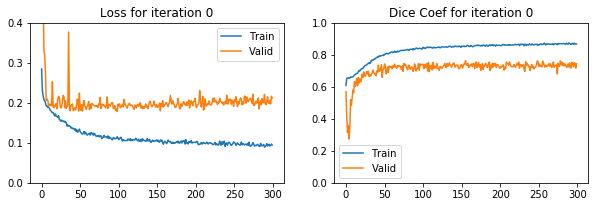

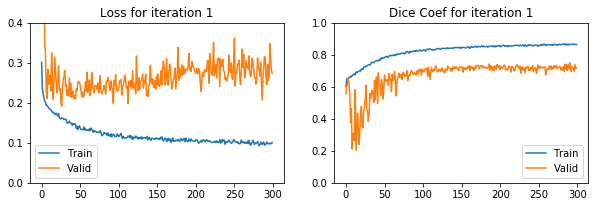

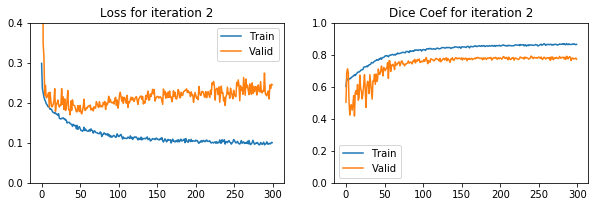

In [246]:
for i  in range(3):
    history_path = ['/home/malub_local/history/0927_1446_40_history_iter_0_.txt', 
                    "/home/malub_local/history/0927_1547_41_history_iter_1_.txt", 
                    "/home/malub_local/history/0927_1640_30_history_iter_2_.txt"] 
    loss, val_dice_coef, val_loss, dice_coef = read_history(history_path[i])
    fig, ax = plt.subplots(figsize = (10, 10))
    plt.subplot(320 + 2*i + 1)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title("Loss for iteration " + str(i))
    plt.legend(["Train", "Valid"])
    plt.ylim(0, 0.4)
    plt.subplot(320 + 2*i + 2)
    plt.plot(dice_coef)
    plt.plot(val_dice_coef)
    plt.title("Dice Coef for iteration " + str(i))
    plt.legend(["Train", "Valid"])
    plt.ylim(0, 1)
    plt.show()

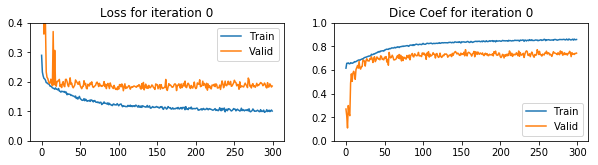

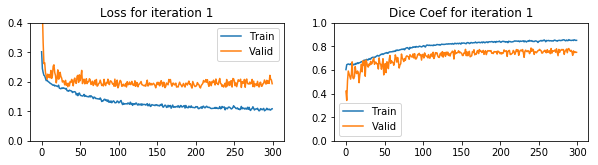

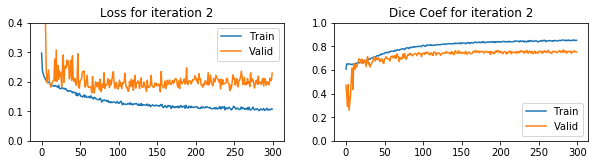

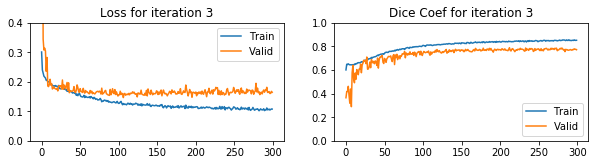

In [253]:
for i  in range(4):
    history_path = ['/home/malub_local/history/0928_1153_29_history_iter_0_.txt', 
                    "/home/malub_local/history/0928_1254_47_history_iter_1_.txt", 
                    "/home/malub_local/history/0928_1347_32_history_iter_2_.txt",
                   "/home/malub_local/history/0928_1440_08_history_iter_3_.txt"] 
    loss, val_dice_coef, val_loss, dice_coef = read_history(history_path[i])
    fig, ax = plt.subplots(figsize = (10, 10))
    plt.subplot(420 + 2*i + 1)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title("Loss for iteration " + str(i))
    plt.legend(["Train", "Valid"])
    plt.ylim(0, 0.4)
    plt.subplot(420 + 2*i + 2)
    plt.plot(dice_coef)
    plt.plot(val_dice_coef)
    plt.title("Dice Coef for iteration " + str(i))
    plt.legend(["Train", "Valid"])
    plt.ylim(0, 1)
    plt.show()

## Display segmentation for X_test 

In [254]:
uncertain_test, uncertain_map_test, predictions_test = uncertainty_for_ranking(model, X_test)

Computing predictions for unlabelled data ...



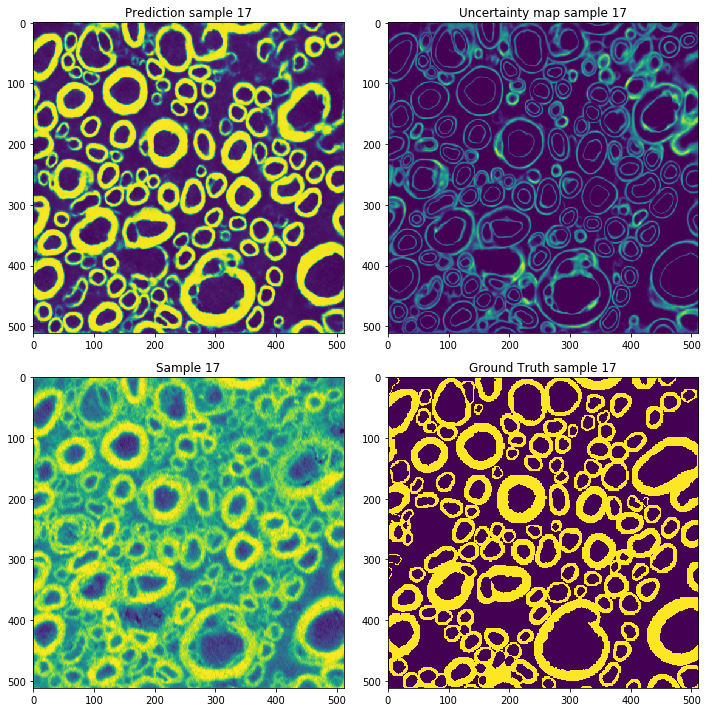

In [264]:
# Plot predictions and uncertainty map for 2 samples 
rand_int = random.randint(0, len(X_test)-1)
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(predictions_test[rand_int][0,:,:])
plt.title("Prediction sample " + str(rand_int))
plt.subplot(222)
plt.imshow(uncertain_map_test[rand_int])
plt.title("Uncertainty map sample "+ str(rand_int))
plt.subplot(223)
plt.imshow(X_test[rand_int][0,:,:])
plt.title("Sample "+ str(rand_int))
plt.subplot(224)
plt.imshow(y_test[rand_int][0,:,:])
plt.title("Ground Truth sample "+ str(rand_int))
plt.tight_layout()
plt.show()


## Choose threshold 

In [190]:
# uncertainty computation
dice_coef_test = np.zeros(len(X_test))
dice = []

print("Computing log predictions ...\n")
predictions = predict(X_test, model)

for threshold in np.arange(0, 1, 0.05):
    dice_coef_test = np.zeros(len(X_test))
    for i in range(len(X_test)):
        sample = X_test[i].reshape([1, 1, img_rows, img_cols])
        sample_prediction = cv2.threshold(predictions[i], threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')
        dice_coef_test[i] = compute_dice_coef(y_test[i][0], sample_prediction)
    dice.append(np.mean(dice_coef_test))


print(len(dice))
print("Done")


Computing log predictions ...

20
Done


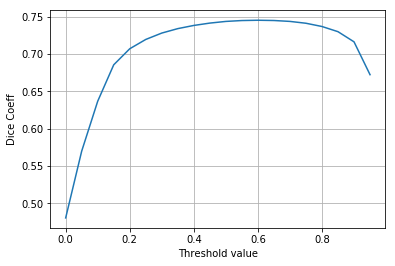

In [147]:
plt.plot(np.arange(0, 1, 0.05), dice )
plt.suptitle("Average over the entire test set", fontsize = 20)
plt.ylabel("Dice Coeff", fontsize = 20)
plt.xlabel("Threshold value", fontsize = 20)
plt.grid()
#plt.ylim(0.7, 0.75)
plt.show()

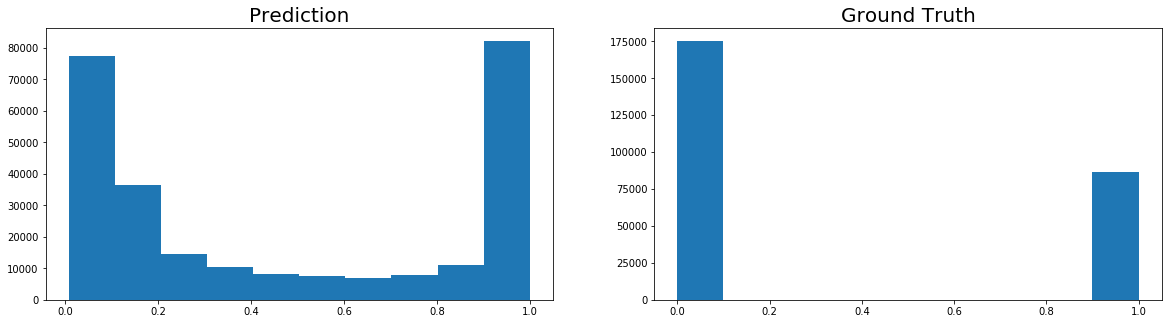

In [203]:
plt.figure(figsize=(20,5))
plt.suptitle("Average over the entire test set", fontsize = 20)
plt.subplot(121)
plt.hist(predictions[0].flatten())
plt.title("Prediction", fontsize = 20)
plt.subplot(122)
plt.hist(y_test[0].flatten())
plt.title("Ground Truth", fontsize = 20)
plt.show()

# Visuaize Data Augmentation

In [ ]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

def visualize_data_augmentation(generator):
    batch1 = take(1, generator)
    max_images = 16
    grid_width = 8
    grid_height = 1
    fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
    for i in range(8):
        img = batch1[0][0][i, 0, :, :]
        mask = batch1[0][1][i, 0, :, :]
        ax = axs[ i % grid_width]
        ax.imshow(img, cmap="gray")
        ax.set_yticklabels([])
        ax.set_xticklabels([])


    fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 10))
    for i in range(8):
        img = batch1[0][0][i, 0, :, :]
        mask = batch1[0][1][i, 0, :, :]
        ax = axs[ i % grid_width]
        ax.imshow(mask, cmap="gray")
        ax.set_yticklabels([])
        ax.set_xticklabels([])

In [ ]:
visualize_data_augmentation(train_generator)